In [1]:
import numpy as np
import pandas as pd
from IPython.display import clear_output
from matplotlib import pyplot as plt

# 加载数据集。
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
# label
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [2]:
import tensorflow as tf
tf.random.set_seed(123)

In [3]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [19]:
dftrain.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,627.0,29.631308,12.511818,0.75,23.0000,28.0000,35.0000,80.0000
n_siblings_spouses,627.0,0.545455,1.151090,0.00,0.0000,0.0000,1.0000,8.0000
parch,627.0,0.379585,0.792999,0.00,0.0000,0.0000,0.0000,5.0000
fare,627.0,34.385399,54.597730,0.00,7.8958,15.0458,31.3875,512.3292


<AxesSubplot:>

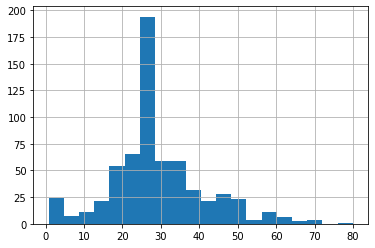

In [29]:
dftrain.age.hist(bins=20)

<AxesSubplot:>

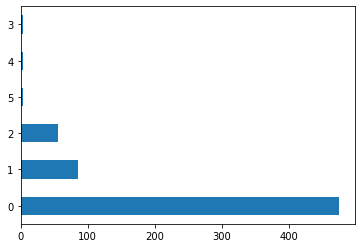

In [45]:
dftrain.parch.value_counts().plot(kind='barh')

<AxesSubplot:>

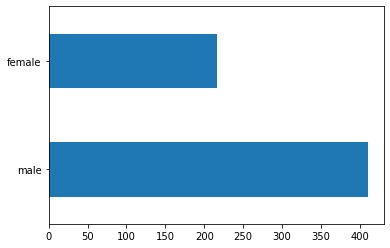

In [49]:
dftrain.sex.value_counts().plot(kind='barh')

<AxesSubplot:>

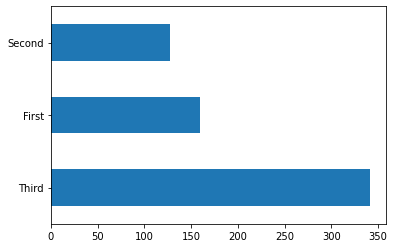

In [50]:
dftrain['class'].value_counts().plot(kind='barh')

In [51]:
full_dftrain = pd.concat([dftrain, y_train], axis=1)
full_dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone,survived
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n,0
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n,1
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y,1
3,female,35.0,1,0,53.1000,First,C,Southampton,n,1
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y,0


Text(0.5, 0, '% survive')

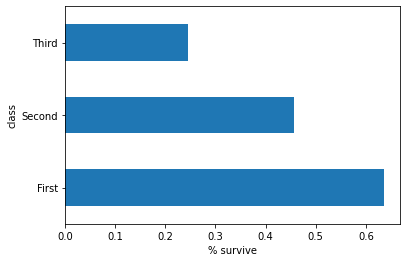

In [52]:
# 看一下不同等级舱对存活率的影响
full_dftrain.groupby('class').survived.mean().plot(kind='barh').set_xlabel("% survive")

Text(0.5, 0, '% survive')

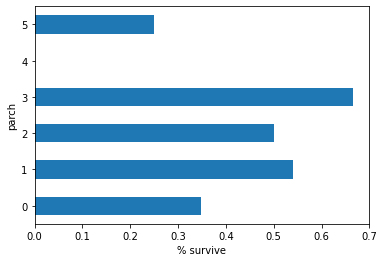

In [53]:
# 看一下有父母小孩对存货率的影响
full_dftrain.groupby('parch').survived.mean().plot(kind='barh').set_xlabel('% survive')

Text(0.5, 0, '% survive')

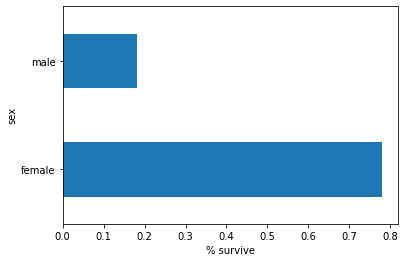

In [54]:
# 看一下有父母小孩对存货率的影响
full_dftrain.groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')

## Feature Engineering

In [69]:
fc = tf.feature_column
feature_columns = []

In [70]:
CATEGORICAL_COLUMNS = ['sex', 
                       'n_siblings_spouses', 
                       'parch', 
                       'class', 
                       'deck',
                       'embark_town', 
                       'alone']
NUMERIC_COLUMNS = ['age', 'fare']

In [71]:
def one_hot_cat_column(feature_name, vocab):
    return fc.indicator_column(fc.categorical_column_with_vocabulary_list(feature_name, vocab))

In [72]:
# categorical feature columns
for feature_name in CATEGORICAL_COLUMNS:
    vocabulary = dftrain[feature_name].unique()
    feature_columns.append(one_hot_cat_column(feature_name, vocabulary))

In [77]:
# numerical feature columns
for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(fc.numeric_column(feature_name, dtype=tf.float32))

### 抽一个样本看一下经过转换后的特征列

In [114]:
example = dict(dftrain.head(1))
print("example raw:", example)
tf.keras.layers.DenseFeatures(feature_columns)(example).numpy()

example raw: {'sex': 0    male
Name: sex, dtype: object, 'age': 0    22.0
Name: age, dtype: float64, 'n_siblings_spouses': 0    1
Name: n_siblings_spouses, dtype: int64, 'parch': 0    0
Name: parch, dtype: int64, 'fare': 0    7.25
Name: fare, dtype: float64, 'class': 0    Third
Name: class, dtype: object, 'deck': 0    unknown
Name: deck, dtype: object, 'embark_town': 0    Southampton
Name: embark_town, dtype: object, 'alone': 0    n
Name: alone, dtype: object}


array([[22.  ,  1.  ,  0.  ,  1.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,
         7.25,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ]], dtype=float32)

In [115]:
# 使用大小为全部数据的 batch ，因为数据规模非常小.
NUM_EXAMPLES = len(y_train)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
    def input_fn():
        dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
        if shuffle:
            dataset = dataset.shuffle(NUM_EXAMPLES)
        # 对于训练，可以按需多次循环数据集（n_epochs=None）。
        dataset = dataset.repeat(n_epochs)
        # 在内存中训练不使用 batch。
        dataset = dataset.batch(NUM_EXAMPLES)
        return dataset
    return input_fn

# 训练与评估的输入函数。
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, shuffle=False, n_epochs=1)

## 使用线性分类训练

In [116]:
linear_est = tf.estimator.LinearClassifier(feature_columns)

# 训练模型。
linear_est.train(train_input_fn, max_steps=100)

# 评估。
result = linear_est.evaluate(eval_input_fn)
clear_output()
print(pd.Series(result))

accuracy                  0.765152
accuracy_baseline         0.625000
auc                       0.832844
auc_precision_recall      0.789631
average_loss              0.478908
label/mean                0.375000
loss                      0.478908
precision                 0.703297
prediction/mean           0.350790
recall                    0.646465
global_step             100.000000
dtype: float64


## 使用 Boosted Tree 训练

In [117]:
# 由于数据存入内存中，在每层使用全部数据会更快。
# 上面一个 batch 定义为整个数据集。
n_batches = 1
est = tf.estimator.BoostedTreesClassifier(feature_columns,
                                          n_batches_per_layer=n_batches)

# 一旦建立了指定数量的树，模型将停止训练，
# 而不是基于训练步数。
est.train(train_input_fn, max_steps=100)

# 评估。
result = est.evaluate(eval_input_fn)
clear_output()
print(pd.Series(result))

accuracy                  0.833333
accuracy_baseline         0.625000
auc                       0.874931
auc_precision_recall      0.859920
average_loss              0.405004
label/mean                0.375000
loss                      0.405004
precision                 0.795699
prediction/mean           0.383333
recall                    0.747475
global_step             100.000000
dtype: float64


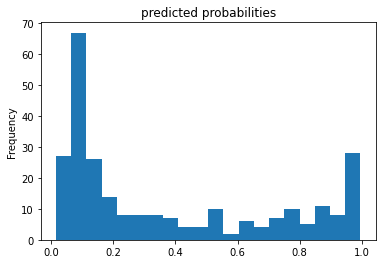

In [121]:
pred_dicts = list(est.predict(eval_input_fn))
clear_output()
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')
plt.show()

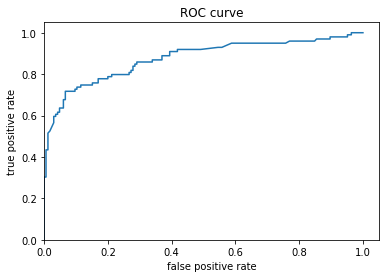

In [119]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)
plt.show()

In [120]:
probs

0      0.104759
1      0.301604
2      0.374438
3      0.398716
4      0.175613
         ...   
259    0.614561
260    0.075740
261    0.112931
262    0.096836
263    0.552366
Length: 264, dtype: float64